# Project 3 - Water Pump Clasificaiton

## Executive Summary

Text

# Notes

Things to add to my project - ideas from class

* SQL
* dummy set
* linear svm
* tableau


# Setup

In [1]:
from __future__ import print_function

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import division
pd.set_option('display.width',5000)

In [3]:
import patsy

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Import - Training Data

This data is part of the Data Driven Competition

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/


In [4]:
# 'Values' provided for each pump location - features

df_values = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/Training set values.csv')
df_values.sample(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
28766,45716,0.0,2012-10-29,Tasaf,0,DWE,0.000000,-2.000000e-08,S,0,...,other,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
9373,74144,0.0,2012-10-08,Wsdp,0,DWE,33.531404,-3.591372e+00,Kwa Mzee Kabupu,0,...,per bucket,salty,salty,insufficient,insufficient,hand dtw,borehole,groundwater,hand pump,hand pump
15523,63822,0.0,2012-11-13,Tasaf,0,TASAF,33.202760,-5.196147e+00,Miziwaziwa,0,...,unknown,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
40347,30195,0.0,2011-07-27,Kyela Council,0,DWE,33.885344,-9.453984e+00,Kwa Anyigwile Mwangungulu,0,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
17742,34680,0.0,2013-02-12,Government Of Tanzania,1345,Government,29.998239,-4.361256e+00,Buha Secondary,0,...,never pay,soft,good,enough,enough,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
# 'Labels' provided for each pump location - clasificaiton - what I am predicting

df_labels = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/Training set labels.csv')
df_labels.sample(5)

,id,status_group
5947,50486,functional
17800,7566,functional needs repair
31811,42923,non functional
26603,16832,functional
29918,69282,functional


# Exploratory Data Analysis

## Colum descriptions

My goal is to predict the operating condition of a waterpoint for each record in the dataset. I was provided the following set of information about the waterpoints:

* amount_tsh - Total static head (amount water available to waterpoint)
    * 98 unique
* date_recorded - The date the row was entered
    * 365 unique
    * year - month - day
* funder - Who funded the well
    * 1897 unique
    * look at top ones?
* installer - Organization that installed the well
    * 2145 unique
    * DWE is main one - 10x closest other, 17k
* wpt_name - Name of the waterpoint if there is one
    * 37400 unique
    * look at top ones?
* num_private - (NO PROVIDED DESC)
    * 65 unique
    * USELESS FEATURE
* population - Population around the well
    * 1049 unique
    * a lot are zero
* public_meeting - True/False
    * 2 unique
* recorded_by - Group entering this row of data
    * 1 unique
    * all the same - USELESS FEATURE
* scheme_management - Who operates the waterpoint
    * 12 unique
* scheme_name - Who operates the waterpoint
    * 2696 unique
    * USELESS FEATURE
* permit - If the waterpoint is permitted
    * 2 unique
* construction_year - Year the waterpoint was constructed
    * 55 unique
    * third are 0 - USELESS FEATURE


* Geography
    * gps_height - Altitude of the well
        * numerical
    * longitude - GPS coordinate
        * numerical
    * latitude - GPS coordinate
        * numerical
    * basin - Geographic water basin
        * 9 unique
    * subvillage - Geographic location
        * 19287 unique
    * region - Geographic location
        * 21 unique
    * region_code - Geographic location (coded)
        * 27 unique
    * district_code - Geographic location (coded)
        * 20 unique
    * lga - Geographic location
        * 125 unique
    * ward - Geographic location
        * 2092 unique


* Extraction
    * extraction_type - The kind of extraction the waterpoint uses
        * 18 unique
        * Most descriptive of extraction
    * extraction_type_group - The kind of extraction the waterpoint uses
        * 13 unique
        * Parent of extraction_type
    * extraction_type_class - The kind of extraction the waterpoint uses
        * 7 unique
        * Parent of extraction_type_group


* Overhead
    * management - How the waterpoint is managed
        * 12 unique
    * management_group - How the waterpoint is managed
        * 5 unique
    * payment - What the water costs
        * 7 unique
        * same as payment type
    * payment_type - What the water costs
        * 7 unique
        * same as payment


* Water
    * water_quality - The quality of the water 
        * 3 unique
        * Subset of quality_group
    * quality_group - The quality of the water
        * 6 unique
        * Parent group of water_quality
    * quantity - The quantity of water
        * 5 unique
        * Same as quantity_group
    * quantity_group - The quantity of water
        * 5 unique
        * Same as quantity
    * source - The source of the water
        * 10 unique
    * source_type - The source of the water
        * 7 unique
        * Subset of source
    * source_class - The source of the water
        * 3 unique
        * Subset of source_type
    * waterpoint_type - The kind of waterpoint
        * 6 unique
        * Parent of waterpoint_type_group
    * waterpoint_type_group - The kind of waterpoint
        * 7 unique
        * Subset of waterpoint_type

## Various EDA

##### Status

In [6]:
# 3 Unique status present
df_labels.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

##### Finding features

##### Review histograms of extraction data

* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses

18

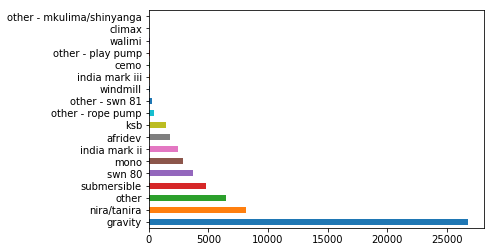

In [7]:
df_values.extraction_type.value_counts().plot('barh')
len(df_values.extraction_type.value_counts())

13

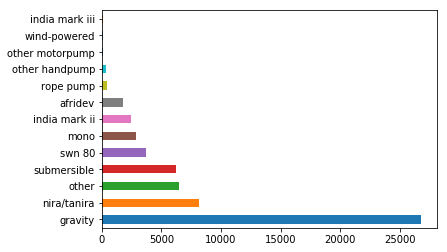

In [8]:
df_values.extraction_type_group.value_counts().plot('barh')
len(df_values.extraction_type_group.value_counts())

7

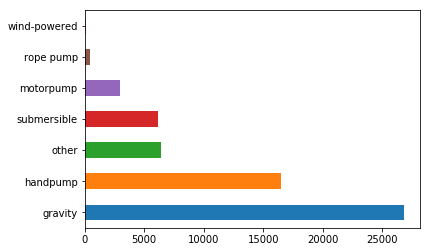

In [9]:
df_values.extraction_type_class.value_counts().plot('barh')
len(df_values.extraction_type_class.value_counts())

##### Other

In [10]:
# df_values.population.value_counts()

In [11]:
len(df_values.ward.value_counts())

2092

In [12]:
# len(df_values.management.value_counts())

In [13]:
# print(df_values.region.value_counts())
# print('Length: ',len(df_values.region.value_counts()))

In [14]:
#print(df_values.region_code.value_counts())
#print('Length: ',len(df_values.region_code.value_counts()))

In [15]:
# df_values.water_quality.value_counts()

In [16]:
#df_values.installer.value_counts()

# Test Train Split

In [17]:
# randomize data
# df_lables, df_values - combine and shuffle this data

df = pd.merge(df_labels,df_values,how = 'left')
df = df.sample(frac=1).reset_index(drop=True)

In [18]:
# Split back to X and y and then TTS
y = df[["id","status_group"]]
X = df.drop('status_group', axis=1)

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Data Import - Challenge Data

In [19]:
# 'Values' provided for each competition pump location - features

df_test_values = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/Test set values.csv')
df_test_values.sample(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
12447,41457,0.0,2011-04-12,Socie,0,Commu,35.868631,-5.974713e+00,Kwa Andrea,0,...,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
2454,38928,0.0,2011-03-07,Dwe,1723,DWE,34.925542,-9.337982e+00,none,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
8770,24857,0.0,2012-11-05,Hesawa,1233,DWE,33.768597,-1.968043e+00,Kwa Jonas Mnubi,0,...,unknown,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
7919,9948,0.0,2011-07-24,Wsdp,0,DWE,0.000000,-2.000000e-08,Makumbusho,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
13197,1958,500.0,2011-02-22,Danida,1687,Danid,34.498792,-9.851876e+00,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [20]:
# 'Labels' I will provide for each pump location - clasificaiton

df_sub = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/SubmissionFormat.csv')
df_sub.sample(5)

,id,status_group
384,60169,predicted label
13816,65811,predicted label
5594,41938,predicted label
13214,21631,predicted label
8690,62465,predicted label


In [21]:
df_sub = df_sub.drop('status_group', axis = 1)
df_sub.sample(5)

,id
8842,73221
11874,44998
3740,12399
5835,55617
10572,11626


# Dummy Classification

Functional is the highest output

In [22]:
# set everything to functional - most common - and submit for a baseline

df_sub['status_group'] = pd.Series('functional', index=df_sub.index)
df_sub.to_csv('./Submissions/dummy_classification.csv',index=False)

<table>
  <tr>
    <th>Best</th>
    <th>Current Rank</th>
    <th>Competitors</th>
    <th>Time</th>
  </tr>
  <tr>
    <td>0.5461</td>
    <td>1342</td>
    <td>5030</td>
    <td>May 3, 2018, 8:37 p.m.</td>
  </tr>
</table>

# (Classification 2)

In [23]:
df.sample(5)

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
22655,42760,functional needs repair,250.0,2013-02-09,Imf,1297,Government,29.885781,-4.483254,Kwa Omary,...,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
18938,74239,non functional,1000.0,2011-03-18,Government Of Tanzania,2140,Commu,33.926871,-8.960687,none,...,on failure,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
41176,13221,functional needs repair,5000.0,2013-07-03,Isf,519,ISF,38.053607,-4.305400,Kwa Khatibu,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
9588,32508,non functional,0.0,2011-03-22,Plan Int,287,Hydrotec,36.771817,-8.071894,Kwamamangwega,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
26184,27278,non functional,50.0,2013-01-31,Jaica,37,Jaica,40.091113,-10.397692,Kwa Robo,...,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump


In [24]:
# try with a few less features first 

feature_no_sel = df[['amount_tsh', 'date_recorded', 'funder', 'installer', 
                   'wpt_name', 'num_private', 'subvillage', 'region', 
                   'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by', 
                   'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 
                   'extraction_type_group', 'management', 'management_group', 'payment', 
                   'payment_type', 'water_quality', 'quality_group', 'quantity_group', 'source', 
                   'source_type', 'waterpoint_type','region_code', 
                  'district_code']]

feature_sel = df[['id', 'status_group', 'gps_height', 'longitude', 'latitude', 'basin',
                  'extraction_type_class','payment','quantity','water_quality', 'source_class',
                  'waterpoint_type_group','population','public_meeting','scheme_management']]

In [25]:
feature_sel.head(5)

,id,status_group,gps_height,longitude,latitude,basin,extraction_type_class,payment,quantity,water_quality,source_class,waterpoint_type_group,population,public_meeting,scheme_management
0,42799,non functional,359,37.752453,-7.039106,Wami / Ruvu,handpump,never pay,insufficient,coloured,groundwater,hand pump,1,True,VWC
1,39619,functional needs repair,0,33.651389,-9.348824,Lake Nyasa,gravity,never pay,insufficient,soft,surface,communal standpipe,0,True,VWC
2,15667,non functional,1227,37.524070,-3.306861,Pangani,gravity,never pay,enough,soft,groundwater,other,1,False,VWC
3,14990,non functional,1604,34.902608,-4.552824,Internal,submersible,pay per bucket,insufficient,soft,groundwater,communal standpipe,200,True,VWC
4,19246,functional,1006,35.451014,-10.596787,Lake Nyasa,gravity,pay when scheme fails,enough,soft,surface,communal standpipe,0,True,VWC


In [26]:
# Change what I predict to 1,2,3

for i in range(len(feature_sel.status_group)):
    if feature_sel.status_group[i] == 'functional':
        feature_sel.at[i, 'status_group'] = 3
    elif feature_sel.status_group[i] == 'functional needs repair':
        feature_sel.at[i, 'status_group'] = 2
    else:
        feature_sel.at[i, 'status_group'] = 1
    

In [27]:
feature_sel=feature_sel.drop('id', axis=1)

In [28]:
# rearange columns
cols = feature_sel.columns.tolist()
cols = ['status_group',
             'gps_height',
             'longitude',
             'latitude',
             'population',
             'basin',
             'extraction_type_class',
             'payment',
             'quantity',
             'water_quality',
             'source_class',
             'waterpoint_type_group',
             'public_meeting',
             'scheme_management']
feature_sel = feature_sel[cols]

In [29]:
#create dummy features for applicabe

feature_sel = pd.get_dummies(feature_sel,columns=list(feature_sel.columns[5:]))
feature_sel.sample(5)

,status_group,gps_height,longitude,latitude,population,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,...,scheme_management_Other,scheme_management_Parastatal,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority
8660,3,2116,33.930396,-8.958925,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
14788,3,1149,36.847848,-3.380195,350,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24303,3,0,30.651349,-2.531497,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
51013,2,0,31.752688,-1.490695,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
30591,1,500,38.050884,-4.362551,250,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [30]:
columns = list(feature_sel.columns)
feature_sel[columns[5:]] = feature_sel[columns[5:]].astype(int)
feature_sel[columns[0]] = feature_sel[columns[0]].astype(int)

In [32]:
feature_sel = feature_sel.sample(frac=1).reset_index(drop=True)
y = feature_sel.status_group
X = feature_sel.drop('status_group', axis=1)

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
y_train.shape

(47520,)

# From class on SVM

In [34]:
from __future__ import print_function

import numpy as np
import pandas as pd

from IPython.display import Image

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn import svm

from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
pd.Series(y_train).value_counts()

3    25855
1    18236
2     3429
Name: status_group, dtype: int64

## Principle Component Analysis

In [36]:
pca = PCA(n_components=2)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [37]:
pcafeatures_train = pca.transform(X_train)

In [38]:
from itertools import cycle

In [39]:
# def plot_PCA_2D(data, target, target_names):
#     colors = cycle(['r','g','b'])
#     target_ids = range(len(target_names))
#     plt.figure()
#     for i, c, label in zip(target_ids, colors, target_names):
#         plt.scatter(data[target == i, 0], data[target == i, 1],
#                    c=c, label=label)
#     plt.legend()

In [40]:
# plot_PCA_2D(pcafeatures_train, target=y_train, target_names=digits.target_names)

## Fitting Linear and RBF SVM Models

In [ ]:
# fit linear model
model_svm = svm.SVC(kernel='rbf')
model_svm.fit(X_train, y_train)

In [ ]:
# predict out of sample
y_pred = model_svm.predict(X_test)

In [ ]:
# check accuracy
accuracy_score(y_test,y_pred)

In [ ]:
# confusion matrix
confusion_matrix(y_test,y_pred)

In [ ]:
# fit rbf model
model_svm2 = svm.SVC(kernel='rbf', gamma = 0.001)
model_svm2.fit(X_train, y_train)

In [ ]:
# predict out of sample
y_pred2 = model_svm2.predict(X_test)

In [ ]:
# check accuracy
accuracy_score(y_test,y_pred2)

In [ ]:
# confusion matrix
confusion_matrix(y_test,y_pred2)

# Appendix

Extra code from class to utilize

In [8]:
df.age=df.age.fillna(df.age.mean())

In [10]:
y,X=dmatrices('survived~ pclass +age+sibsp+parch+fare',data=df,return_type='dataframe')

In [11]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

Training Data Accuracy: 0.71
Test Data Accuracy:     0.70
[[97 12]
 [42 28]]


Precision:              0.70
Recall:                 0.89


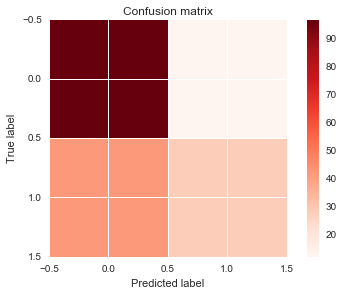

In [17]:
log_clf=LogisticRegression()
train_score(log_clf,X,y)

Text(0,0.5,'TPR')

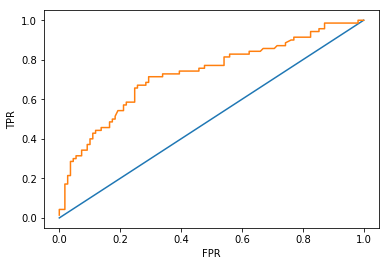

In [16]:
# What about ROC ? 

from sklearn.metrics import roc_curve, auc

xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)
log = LogisticRegression()
log.fit(xtrain,np.ravel(ytrain))
y_score=log.predict_proba(xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [20]:
tpr

array([0.01428571, 0.04285714, 0.04285714, 0.17142857, 0.17142857,
       0.21428571, 0.21428571, 0.28571429, 0.28571429, 0.3       ,
       0.3       , 0.31428571, 0.31428571, 0.34285714, 0.34285714,
       0.37142857, 0.37142857, 0.4       , 0.4       , 0.42857143,
       0.42857143, 0.44285714, 0.44285714, 0.45714286, 0.45714286,
       0.48571429, 0.48571429, 0.5       , 0.5       , 0.51428571,
       0.54285714, 0.54285714, 0.57142857, 0.57142857, 0.58571429,
       0.58571429, 0.58571429, 0.6       , 0.62857143, 0.65714286,
       0.65714286, 0.67142857, 0.67142857, 0.68571429, 0.68571429,
       0.71428571, 0.71428571, 0.71428571, 0.72857143, 0.72857143,
       0.74285714, 0.74285714, 0.74285714, 0.74285714, 0.75714286,
       0.75714286, 0.77142857, 0.77142857, 0.81428571, 0.81428571,
       0.82857143, 0.82857143, 0.84285714, 0.84285714, 0.84285714,
       0.85714286, 0.85714286, 0.85714286, 0.87142857, 0.87142857,
       0.87142857, 0.88571429, 0.9       , 0.9       , 0.91428

####  Cost Benefit Example: 

We can also optimize our models based on specific costs associated with our classification errors; here we will use specific dollar amounts as weights.

Let's say we were developing a classification model for Aircraft Delay prediction.  For this example let's assume that a true positive would 
lead to a cost savings of 2160 dollars, a false negative would cost us 2900 dollars a false positive would cost 750 dollars.  

cb = np.array([[2160, -750.0], [-2900, 0]])  

Expected_Value = #TPs(2160) - #FNs(2900) -#FPs(750)  

# New heading